# 보조지표 매매 전략 - AI

과거 데이터를 통해 구축된 AI 예측 모형으로 미래 가격 움직임을 예측
- 사용 가능한 데이터
    1. 과거 종가, 거래량 증감률
    2. 보조지표
    3. 요일 등

## 결정 트리(Decision Tree, DT)

대표적인 예측 머신러닝 모델으로 질문의 모음으로 구성. 뿌리(root)에서 시작하여 조건에 따라 노드를 이동하여 하단의 경로로 내려가 최종 리프에 도달하여 예측

- 일반적으로 질문을 통해 하위 2개의 노드로 분리
- 하단 경로로 내려갈수록 데이터들이 잘 분류됨

과거 데이터를 통해, 분류 혹은 예측을 가장 잘하는 트리 모델을 구하는 것을 학습이라고 함

## 1. 필요한 패키지 import

In [3]:
# pip install scikit-learn
import pandas as pd
import numpy as np
import ta
from sklearn.tree import DecisionTreeClassifier # 모델
from sklearn.metrics import f1_score # 모델 평가
from sklearn import tree # 모델 그리기
import matplotlib.pyplot as plt


## 2. 데이터 준비

In [4]:
# 데이터 읽기
data_samsung = pd.read_parquet('../dataset/005930.parquet').set_index('timestamp')
data_samsung = data_samsung[data_samsung.volume > 0] # 거래량이 없는(e.g. 토요일) 날짜 제외

# 학습에 사용할 변수 생성
input_cols = []

### 1. n일 전 대비 수익률
n_list = [1, 2, 3, 4, 5, 10, 20, 60]
for n in n_list:
    data_samsung[f'rtn_{n}'] = data_samsung['close'].pct_change(n)
    input_cols.append(f'rtn_{n}')

### 2. n일 전 대비 거래량 증감률
for n in n_list:
    data_samsung[f'rtn_vol_{n}'] = data_samsung['volume'].pct_change(n)
    input_cols.append(f'rtn_vol_{n}')

### 2. 다양한 techinical indicator
ws_list =  [7, 9, 14, 15, 21, 28]
for ws in ws_list:
    data_samsung[f'rsi{ws}'] = ta.momentum.rsi(close=data_samsung['close'], window=ws)
    input_cols.append(f'rsi{ws}')
    
for ws in ws_list:
    data_samsung[f'adx_{ws}'] = ta.trend.adx(high=data_samsung['high'], low=data_samsung['low'], close=data_samsung['close'], window=ws)
    input_cols.append(f'adx_{ws}')

for ws in ws_list:
    data_samsung[f'mfi_{ws}'] = ta.volume.money_flow_index(high=data_samsung['high'], low=data_samsung['low'], close=data_samsung['close'], volume=data_samsung['volume'], window=ws)
    input_cols.append(f'mfi_{ws}')

for ws_s in ws_list:
    for ws_f in ws_list:
        if ws_s > ws_f:
            data_samsung[f'macd_{ws_s}_{ws_f}'] = ta.trend.macd_signal(close=data_samsung['close'], window_slow=ws_s, window_fast=ws_f)
            input_cols.append(f'macd_{ws_s}_{ws_f}')

for ws in ws_list:
    data_samsung[f'stoch_{ws}'] = ta.momentum.stoch(close=data_samsung['close'], high=data_samsung['high'], low=data_samsung['low'], window=ws)
    input_cols.append(f'stoch_{ws}')


### 3. 요일
data_samsung['dayofweek'] = pd.to_datetime(data_samsung.index).dayofweek
input_cols.append('dayofweek')



### 예측하고자 하는 변수: 오늘 종가 대비 n일 후 종가의 등락 여부(1: 오름, 0: 내림)
output_cols = []
for ws in [1, 2, 3, 4, 5, 10, 20, 40, 60]:
    data_samsung[f'label{ws}'] = (data_samsung['close'].shift(-ws) > data_samsung['close']) * 1
    output_cols.append( f'label{ws}')

In [5]:
# 생성된 변수들 및 예측하고자 하는 변수를 포함한 최종 데이터
data_samsung[input_cols + output_cols]

,rtn_1,rtn_2,rtn_3,rtn_4,rtn_5,rtn_10,rtn_20,rtn_60,rtn_vol_1,rtn_vol_2,...,dayofweek,label1,label2,label3,label4,label5,label10,label20,label40,label60
timestamp,,,,,,,,,,,,,,,,,,,,,
20100104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,1,1,1,0,1,0,0,1
20100105,0.016069,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.337178,NaN,...,1,1,0,0,0,0,1,0,0,1
20100106,0.023114,0.039555,NaN,NaN,NaN,NaN,NaN,NaN,-0.177862,0.921482,...,2,0,0,0,0,0,0,0,0,1
20100107,-0.033294,-0.010949,0.004944,NaN,NaN,NaN,NaN,NaN,-0.035928,-0.207400,...,3,1,0,0,0,1,1,0,0,1
20100108,0.009840,-0.023781,-0.001217,0.014833,NaN,NaN,NaN,NaN,-0.332641,-0.356618,...,4,0,0,0,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20240423,-0.007884,-0.027062,-0.051508,-0.043093,-0.056250,-0.106509,-0.034527,0.020270,-0.385690,-0.402326,...,1,1,1,1,1,0,0,0,0,0
20240424,0.041060,0.032852,0.012887,-0.012563,-0.003802,-0.059809,-0.016270,0.060729,0.184235,-0.272513,...,2,0,0,0,0,0,0,0,0,0
20240425,-0.029262,0.010596,0.002628,-0.016753,-0.041457,-0.092747,-0.043860,0.039510,-0.298519,-0.169282,...,3,1,1,0,0,0,0,0,0,0


## 3. 제안 매매 알고리즘
- n일 후에 오를 것이라 예측되는 경우 매수하고 떨어질 것이라 예측되는 경우 매도
- train(2010~2019), validation(2020~2021), test(2022~2023)

In [6]:
### 데이터 분리
t1, t2, t3, t4 = '2010', '2020', '2022', '2024'
df_train = data_samsung.loc[(data_samsung.index >= t1) & (data_samsung.index < t2), input_cols + output_cols + ['close']].dropna(axis=0)
df_valid = data_samsung.loc[(data_samsung.index >= t2) & (data_samsung.index < t3), input_cols + output_cols + ['close']].dropna(axis=0) 
df_test = data_samsung.loc[(data_samsung.index >= t3) & (data_samsung.index < t4), input_cols + output_cols + ['close']]        

In [7]:
### 모델 특성 조합 정의
import itertools

max_depth_list = [2, 3, 4, 5] # 결정트리가 자랄 수 있는 최대 길이
min_samples_leaf_list = [30, 50, 60, 80, 100] # 최종 리프에 포함되는 데이터의 수
min_impurity_decrease_list = [0.01, 0.03, 0.05, 0.07, 0.1, 0.2] # 노드가 분리될 수 있는 분류 성능 개선 폭의 최소 기준

# 가능한 파라미터 조합 생성
params = list(itertools.product(*[max_depth_list, min_samples_leaf_list, min_impurity_decrease_list, output_cols]))

In [8]:
### 모든 모델 특성 조합에 대한 학습 진행

from sklearn.tree import DecisionTreeClassifier

dict_model = dict()

for (md, ms, mi, output_col) in params:
    clf = DecisionTreeClassifier(max_depth=md, min_samples_leaf=ms, min_impurity_decrease=mi, class_weight='balanced', random_state=0)
    dict_model[f'{md}_{ms}_{mi}_{output_col}'] = clf.fit(df_train[input_cols], df_train[output_col])

In [9]:
### 각 조합에 대해 학습한 결과 모델을 저장한 dictionary 
dict_model

{'2_30_0.01_label1': DecisionTreeClassifier(class_weight='balanced', max_depth=2,
                        min_impurity_decrease=0.01, min_samples_leaf=30,
                        random_state=0),
 '2_30_0.01_label2': DecisionTreeClassifier(class_weight='balanced', max_depth=2,
                        min_impurity_decrease=0.01, min_samples_leaf=30,
                        random_state=0),
 '2_30_0.01_label3': DecisionTreeClassifier(class_weight='balanced', max_depth=2,
                        min_impurity_decrease=0.01, min_samples_leaf=30,
                        random_state=0),
 '2_30_0.01_label4': DecisionTreeClassifier(class_weight='balanced', max_depth=2,
                        min_impurity_decrease=0.01, min_samples_leaf=30,
                        random_state=0),
 '2_30_0.01_label5': DecisionTreeClassifier(class_weight='balanced', max_depth=2,
                        min_impurity_decrease=0.01, min_samples_leaf=30,
                        random_state=0),
 '2_30_0.01_label10'

In [10]:
# validation 데이터로 우수한 모델 조합 선정

best_score, best_model = 0, ''
for model_name, model in dict_model.items():
    output_col = model_name.split('_')[-1]
    accuracy = model.score(df_valid[input_cols], df_valid[output_col])/df_valid[output_col].mean()
    f1 = f1_score(df_valid[output_col], model.predict(df_valid[input_cols]))
    if f1 > best_score:
        best_score = f1
        best_model = model_name

output_col = best_model.split('_')[-1]
print('우수 모델 조합: ', best_model, ', f1_score=', np.round(best_score, 3), )

# 선정된 최종 모델
final_model = dict_model[best_model]

우수 모델 조합:  2_80_0.01_label40 , f1_score= 0.733


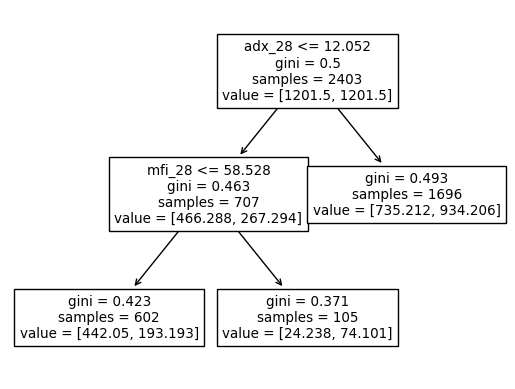

In [11]:
# 최종 모델의 예측 tree plotting
from sklearn import tree
import matplotlib.pyplot as plt

tree.plot_tree(final_model, feature_names=input_cols)
plt.show()

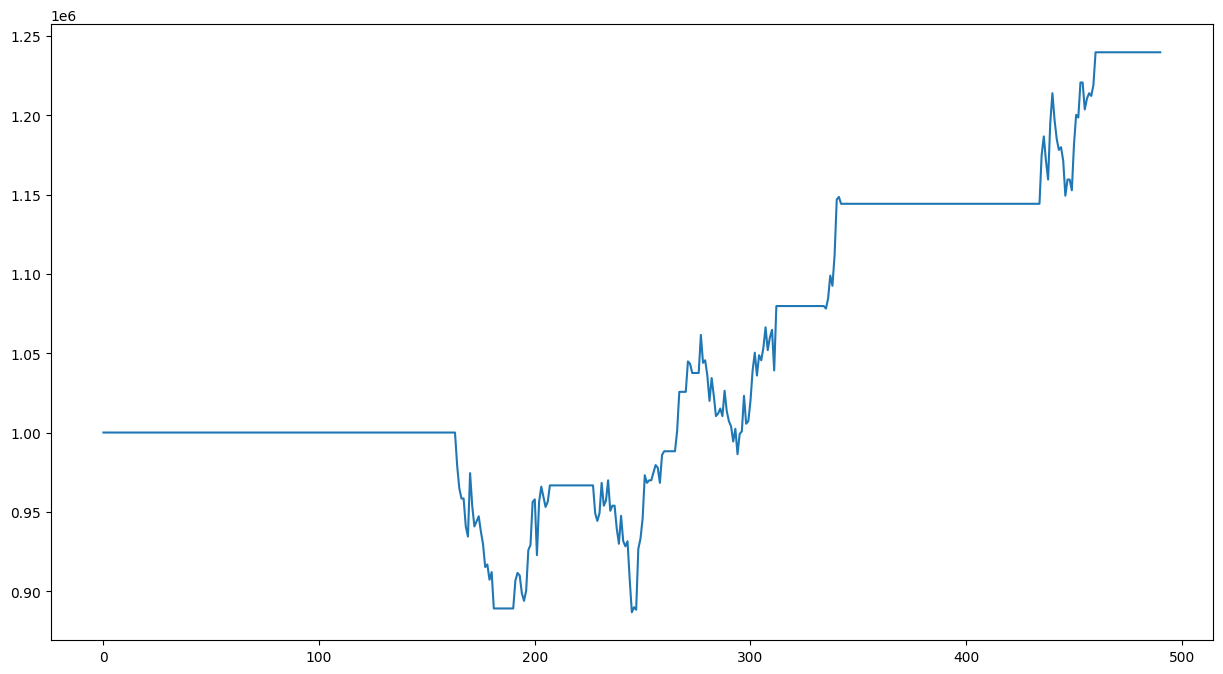

In [12]:
# test 데이터로 성능 평가

holding_cash = 1_000_000 # 보유 현금
position = 0 # 현재 보유 포지션
avg_price = 0 # 평단가
daily_total_value = [] #일별 총 포트폴리오 가치
slippage = 0.0025 # 슬리피지 

thres_bid, thres_ask = 0.5, 0.5 # 상승 예측 확률이 0.5보다 큰 경우 매수, 그렇지 않은 경우 매도

wait = int(best_model.split('_')[-1].replace('label', ''))
days = 0
# 한 row 씩 루프
for idx, row in df_test.iterrows():
    prob_up, _ = final_model.predict_proba(row[input_cols].to_frame().T)[0]

    daily_total_value.append(0) # 일별 포트폴리오 가치 List에 새로운 값 추가

    # 매도: n일 후 상승할 것이라 하락할 것이라 예측되거나, 마지막 상승 예측 후 n일이 지난 경우
    if (position > 0) and ((prob_up < 1-thres_bid) or (days > wait)):    
        holding_cash += (position * row['close']) * (1-slippage) # 포지션 매도 시 세금/수수료를 제한 값만 현금으로 돌아옴
        position = 0
        avg_price = 0


    # 매수: n일 후 상승할 것이라 예측되는 경우
    elif (position == 0) and (prob_up > thres_bid):
        # 주식 매수 시의 현금 감소, 포지션 증가, 평단가 변화 계산
        position = int(holding_cash / row['close'])
        holding_cash -= position * row['close']
        avg_price = row['close']
        
    # 날짜 업데이트: n일 후 상승할 것이라 예측되는 경우, 날짜 count reset
    if prob_up > thres_bid:
        days = 0

    days += 1
    daily_total_value[-1]+= holding_cash+ position* row['close'] # 당일 종료 시점에서 보유 현금 + 주식 평가가치로 총 포트폴리오 가치 계산

plt.figure(figsize=(15,8))
plt.plot(daily_total_value)

## 4. 정량적 성과 측정

총 수익률: 23.97%
------------------------------------------------
총 백테스팅 기간: 1.96년
연 수익률: 11.56%
------------------------------------------------
일 수익률: 0.04%, 일 변동성: 0.01%
Sharpe ratio: 0.86
------------------------------------------------
MDD: -11.33%


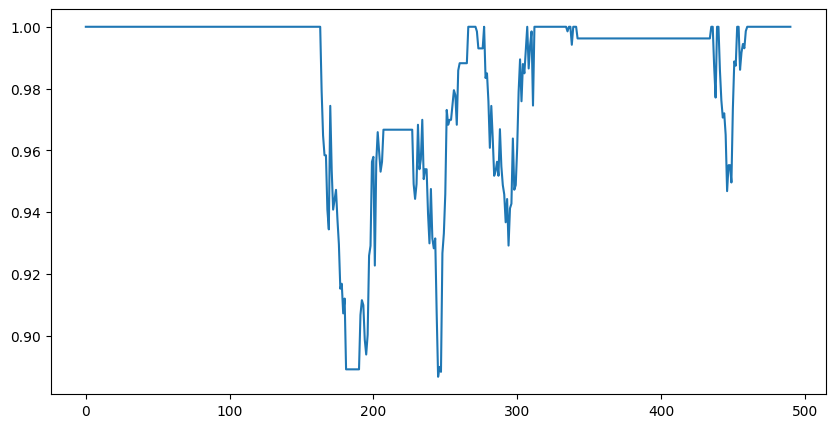

In [14]:
# 전략 총 수익률 계산
total_return_pct = daily_total_value[-1]/daily_total_value[0]
print('총 수익률: {:.2f}%'.format((total_return_pct-1)*100))

print('------------------------------------------------')

# 1년을 250일로 가정, 연 복리 수익률 계산
total_years = len(daily_total_value)/250
print('총 백테스팅 기간: {:.2f}년'.format(total_years))

import math
annaul_return = math.pow(total_return_pct,1/total_years)

print('연 수익률: {:.2f}%'.format((annaul_return-1)*100))

print('------------------------------------------------')

# Sharpe Ratio
daily_return = math.pow(total_return_pct,1/len(daily_total_value))
daily_std = pd.DataFrame(daily_total_value).pct_change().std()[0]

print('일 수익률: {:.2f}%, 일 변동성: {:.2f}%'.format((daily_return-1)*100,daily_std))
print('Sharpe ratio: {:.2f}'.format(((daily_return-1)/daily_std)*np.sqrt(250)))

print('------------------------------------------------')

# MDD 계산
tv = pd.DataFrame(daily_total_value)
dd = tv/tv.cummax()
print('MDD: {:.2f}%'.format((dd.min()-1)[0]*100))


plt.figure(figsize=(10,5))
plt.plot(dd)
plt.show()

## 5. 벤치마크와 비교

총 수익률: -0.13%
------------------------------------------------
총 백테스팅 기간: 1.96년
연 수익률: -0.06%
------------------------------------------------
일 수익률: -0.00%, 일 변동성: 0.01%
Sharpe ratio: -0.00
------------------------------------------------
MDD: -33.33%


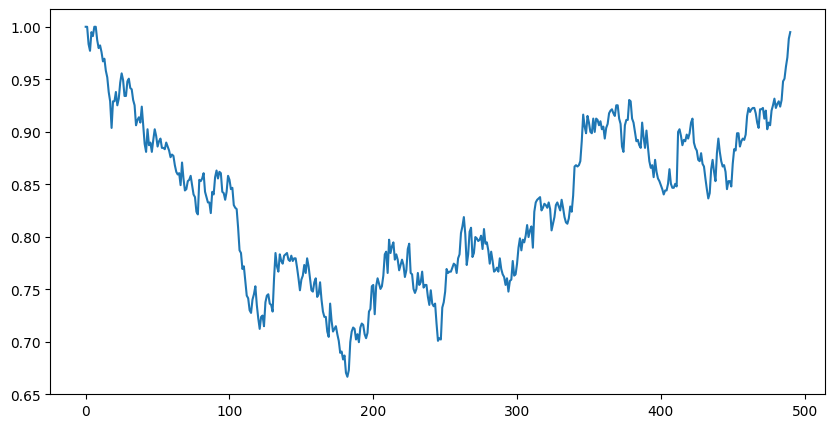

In [15]:
# 삼성전자 Buy & Hold의 수익률 계산

bm_daily_total_value = df_test['close'].values/df_test['close'].values[0]

# 전략 총 수익률 계산
total_return_pct = bm_daily_total_value[-1]/bm_daily_total_value[0]
print('총 수익률: {:.2f}%'.format((total_return_pct-1)*100))

print('------------------------------------------------')

# 1년을 250일로 가정, 연 복리 수익률 계산
total_years = len(bm_daily_total_value)/250
print('총 백테스팅 기간: {:.2f}년'.format(total_years))

import math
annaul_return = math.pow(total_return_pct,1/total_years)

print('연 수익률: {:.2f}%'.format((annaul_return-1)*100))

print('------------------------------------------------')

# Sharpe Ratio
daily_return = math.pow(total_return_pct,1/len(bm_daily_total_value))
daily_std = pd.DataFrame(bm_daily_total_value).pct_change().std()[0]

print('일 수익률: {:.2f}%, 일 변동성: {:.2f}%'.format((daily_return-1)*100,daily_std))
print('Sharpe ratio: {:.2f}'.format(((daily_return-1)/daily_std)*np.sqrt(250)))

print('------------------------------------------------')

# MDD 계산
tv = pd.DataFrame(bm_daily_total_value)
dd = tv/tv.cummax()
print('MDD: {:.2f}%'.format((dd.min()-1)[0]*100))


plt.figure(figsize=(10,5))
plt.plot(dd)
plt.show()